In [ ]:
import tarfile

file = tarfile.open('flower_photos.tgz')
file.extractall('./data')
file.close()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import os
import argparse

import matplotlib.pyplot as plt
import seaborn as sns
import random

In [ ]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
setup_seed(20)

In [ ]:
class FGM():
    def __init__(self, model):
        self.model = model
        self.backup = {}

    def attack(self, epsilon=1, emb_name='head'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name:
                self.backup[name] = param.data.clone()
                norm = torch.norm(param.grad)
                if norm != 0 and not torch.isnan(norm):
                    r_at = epsilon * param.grad / norm
                    param.data.add_(r_at)

    def restore(self, emb_name='head'):
        for name, param in self.model.named_parameters():
            if param.requires_grad and emb_name in name: 
                assert name in self.backup
                param.data = self.backup[name]
        self.backup = {}

In [ ]:
# Training

def train(epoch, net, criterion, trainloader, scheduler):
    device = 'cuda'
    #print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0

    fgm = FGM(net)
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()

        fgm.attack()
        outputs_att = net(inputs)
        loss_att = criterion(outputs_att, targets)
        loss_att.backward()
        fgm.restore()

        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #if (batch_idx+1) % 50 == 0:
         # print("iteration : %3d, loss : %0.4f, accuracy : %2.2f" % (batch_idx+1, train_loss/(batch_idx+1), 100.*correct/total))

    scheduler.step()
    return train_loss/(batch_idx+1), 100.*correct/total

def test(epoch, net, criterion, testloader):
    device = 'cuda'
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.inference_mode():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    return test_loss/(batch_idx+1), 100.*correct/total
     

In [ ]:
import torch.nn as nn
from torchvision.ops import stochastic_depth
from functools import partial

class SE(nn.Module):
    def __init__(self,
                 in_planes,
                 expand_planes,
                 se_ratio = 0.25):
        super(SE, self).__init__()

        squeeze_planes = int(in_planes * se_ratio)
        self.conv_reduce = nn.Conv2d(expand_planes, squeeze_planes, 1)
        self.silu = nn.SiLU()
        self.conv_expand = nn.Conv2d(squeeze_planes, expand_planes, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = x.mean((2, 3), keepdim=True)
        out = self.conv_reduce(out)
        out = self.silu(out)
        out = self.conv_expand(out)
        out = self.sigmoid(out)
        return out * x

class Conv_BN_Act(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 kernel_size = 3,
                 stride = 1,
                 groups = 1,
                 bn_layer = partial(nn.BatchNorm2d, momentum=0.01),
                 activation_layer = nn.SiLU):
        super(Conv_BN_Act, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_planes,
                              out_channels=out_planes,
                              kernel_size=kernel_size,
                              stride=stride,
                              padding=(kernel_size-1)//2,
                              groups=groups,
                              bias=False)

        self.bn = bn_layer(out_planes)
        self.act = activation_layer()

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)

        return out

class MBConv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 stride,
                 drop_rate):
        super(MBConv, self).__init__()

        self.skip_connection = (stride == 1 and in_planes == out_planes)

        expanded_plances = in_planes * expand_ratio

        self.expand_conv = Conv_BN_Act(in_planes, expanded_plances, kernel_size=1)
        self.dw_conv = Conv_BN_Act(expanded_plances, expanded_plances, stride=stride, groups=expanded_plances)
        self.se = SE(in_planes, expanded_plances, 0.25)
        self.project_conv = Conv_BN_Act(expanded_plances, out_planes, kernel_size=1, activation_layer=nn.Identity) 

        if self.skip_connection:
            self.dropout = partial(stochastic_depth, p=drop_rate, model = 'batch')

    def forward(self, x):
        out = self.expand_conv(x)
        out = self.dw_conv(out)
        out = self.se(out)
        out = self.project_conv(out)

        if self.skip_connection:
            out = self.dropout(out)
            out += x

        return out
    
class FusedMBConv(nn.Module):
    def __init__(self,
                 in_planes,
                 out_planes,
                 expand_ratio,
                 stride,
                 drop_rate):
        super(FusedMBConv, self).__init__()

        self.skip_connection = (stride == 1 and in_planes == out_planes)
        self.expansion = expand_ratio != 1

        expanded_plances = in_planes * expand_ratio

        if self.expansion:
            self.expand_conv = Conv_BN_Act(in_planes, expanded_plances, stride=stride)
            self.project_conv = Conv_BN_Act(expanded_plances, out_planes, kernel_size=1, activation_layer=nn.Identity)
        else:
            self.project_conv = Conv_BN_Act(in_planes, out_planes, stride=stride)

        if self.skip_connection:
            self.dropout = partial(stochastic_depth, p=drop_rate, model = 'batch')

    def forward(self, x):
        if self.expansion:
            out = self.expand_conv(x)
            out = self.project_conv(out)
        else:
            out = self.project_conv(out)

        if self.skip_connection:
            out = self.dropout(out)
            out += x

        return out
    
class EfficientNetV2(nn.Module):

    cfgs = [[1,1,1,24,2],[1,4,2,48,4],[1,4,2,64,4],[0,4,2,128,6],[0,6,1,160,9],[0,6,2,256,15]]

    def __init__(self, 
                 num_features = 1280,
                 num_classes = 1000,
                 dropout_rate = 0.2,
                 survival_probability = 0.8):
        super(EfficientNetV2, self).__init__()

        self.stage0 = Conv_BN_Act(3, 24, stride=2)

        self.stage1_6 = self._make_stages(24, survival_probability)

        self.stage7 = nn.Sequential(
            Conv_BN_Act(256, num_features, kernel_size=1),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p=dropout_rate, inplace=True),
            nn.Linear(num_features, num_classes)
        )

        self.apply(self._init_weights)
    
    def _make_stages(self, in_planes, survival_probability):
        operator = [MBConv, FusedMBConv]
        stages = []
        layer_id = 0
        for cfg in self.cfgs:
            for i in range(cfg[4]):
                stages.append(operator[cfg[0]](input_c=in_planes,
                                               out_c=cfg[3],
                                               expand_ratio=cfg[1],
                                               stride=cfg[2] if i == 0 else 1,
                                               drop_rate=(1-survival_probability) * layer_id / 40))
                layer_id += 1
    
    def _init_weights(self, models):
        if isinstance(models, nn.Conv2d):
            nn.init.kaiming_normal_(models.weight, mode="fan_out")
            if models.bias is not None:
                nn.init.zeros_(models.bias)
        elif isinstance(models, nn.BatchNorm2d):
            nn.init.ones_(models.weight)
            nn.init.zeros_(models.bias)
        elif isinstance(models, nn.Linear):
            nn.init.normal_(models.weight, 0, 0.01)
            nn.init.zeros_(models.bias)


    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1_6(out)
        out = self.stage7(out)

        return out

In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset


class MyDataSet(Dataset):

    def __init__(self, images_path: list, images_class: list, transform=None):
        self.images_path = images_path
        self.images_class = images_class
        self.transform = transform

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, item):
        img = Image.open(self.images_path[item])
        label = self.images_class[item]

        if self.transform is not None:
            img = self.transform(img)

        return img, label

    @staticmethod
    def collate_fn(batch):
        images, labels = tuple(zip(*batch))

        images = torch.stack(images, dim=0)
        labels = torch.as_tensor(labels)
        return images, labels

In [ ]:
import os
import sys
import json
import pickle
import random
def read_split_data(root: str, val_rate: float = 0.2):
    random.seed(0)

    flower_class = [cla for cla in os.listdir(root) if os.path.isdir(os.path.join(root, cla))]
    flower_class.sort()
    class_indices = dict((k, v) for v, k in enumerate(flower_class))

    train_images_path = []  
    train_images_label = []  
    val_images_path = []  
    val_images_label = []  
    every_class_num = []  
    supported = [".jpg", ".JPG", ".png", ".PNG"]  
    for cla in flower_class:
        cla_path = os.path.join(root, cla)
        images = [os.path.join(root, cla, i) for i in os.listdir(cla_path)
                  if os.path.splitext(i)[-1] in supported]
        images.sort()
        image_class = class_indices[cla]
        every_class_num.append(len(images))
        val_path = random.sample(images, k=int(len(images) * val_rate))

        for img_path in images:
            if img_path in val_path:  
                val_images_path.append(img_path)
                val_images_label.append(image_class)
            else:  
                train_images_path.append(img_path)
                train_images_label.append(image_class)

    return train_images_path, train_images_label, val_images_path, val_images_label

In [ ]:
import os
import math
import argparse
import random
import torch
import torch.optim as optim

train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./data/flower_photos")
std = [0.5, 0.5, 0.5]
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(300),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(std, std)]),
    "val": transforms.Compose([transforms.Resize(384),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize(std, std)])}

train_dataset = MyDataSet(images_path = train_images_path,images_class = train_images_label,transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=8,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=2,
                                               collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=8,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=2,
                                             collate_fn=val_dataset.collate_fn)

In [ ]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}

net = EfficientNetV2().to('cuda')
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

Epoch :   1, training loss : 1.8206, training accuracy : 30.55, val loss : 1.5963, val accuracy : 46.37
Epoch :   2, training loss : 1.4161, training accuracy : 38.79, val loss : 1.6556, val accuracy : 42.41
Epoch :   3, training loss : 1.3407, training accuracy : 45.08, val loss : 1.1553, val accuracy : 52.94
Epoch :   4, training loss : 1.2847, training accuracy : 47.19, val loss : 1.1352, val accuracy : 57.18
Epoch :   5, training loss : 1.2383, training accuracy : 50.49, val loss : 1.0604, val accuracy : 59.78
Epoch :   6, training loss : 1.1832, training accuracy : 52.77, val loss : 1.0435, val accuracy : 63.06
Epoch :   7, training loss : 1.1774, training accuracy : 53.76, val loss : 1.8030, val accuracy : 64.84
Epoch :   8, training loss : 1.1401, training accuracy : 54.44, val loss : 0.9735, val accuracy : 63.75
Epoch :   9, training loss : 1.0946, training accuracy : 57.26, val loss : 0.9700, val accuracy : 67.31
Epoch :  10, training loss : 1.0855, training accuracy : 57.98, 

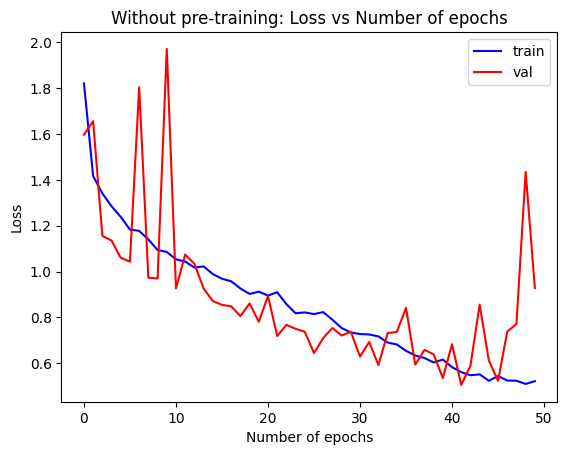

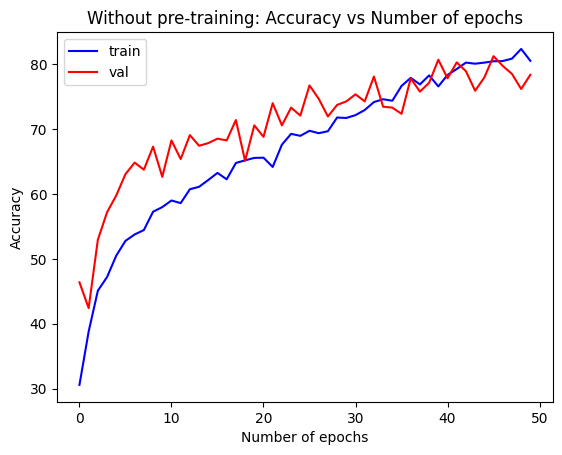

In [ ]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("Without pre-training: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("Without pre-training: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
Epoch :   1, training loss : 1.4195, training accuracy : 57.43, val loss : 0.4606, val accuracy : 84.82
Epoch :   2, training loss : 0.7292, training accuracy : 74.69, val loss : 0.3994, val accuracy : 86.73
Epoch :   3, training loss : 0.5356, training accuracy : 81.73, val loss : 0.2633, val accuracy : 90.97
Epoch :   4, training loss : 0.4879, training accuracy : 83.60, val loss : 0.2544, val accuracy : 93.02
Epoch :   5, training loss : 0.4083, training accuracy : 85.30, val loss : 0.2709, val accuracy : 90.29
Epoch :   6, training loss : 0.3826, training accuracy : 86.53, val loss : 0.2352, val accuracy : 93.16
Epoch :   7, training loss : 0.3545, training accuracy : 87.41, val loss : 0.2028, val accuracy : 95.08
Epoch :   8, training loss : 0.3166, training accuracy : 88.74, val loss : 0.1733, val accuracy : 94.39
Epoch :   9, training loss : 0.3061, training accuracy : 89.49, val loss : 0.2315, val accuracy : 93.57
Epoch :  10, training loss : 0.3

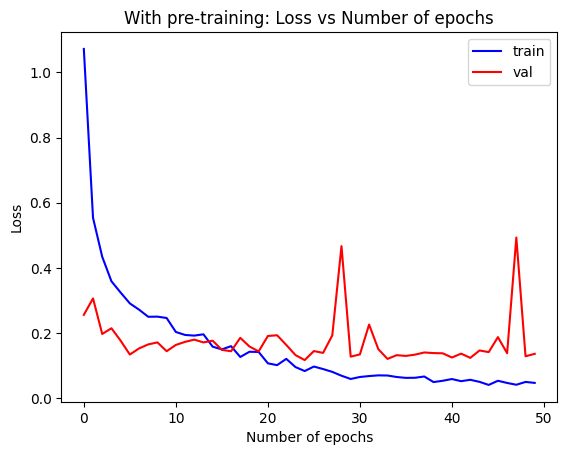

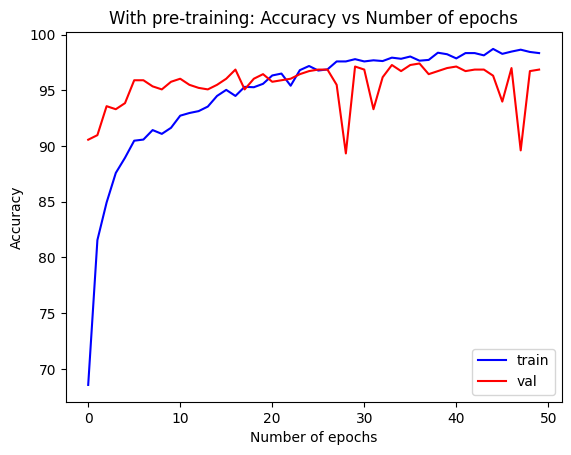

In [ ]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("With pre-training: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("With pre-training: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
config = {
    'lr': 0.01,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

for name, para in net.named_parameters():
    if "head" not in name:
      para.requires_grad_(False)
    else:
      print("training {}".format(name))
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.SGD(net.parameters(), lr=config['lr'],
                      momentum=config['momentum'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
training head.project_conv.conv.weight
training head.project_conv.bn.weight
training head.project_conv.bn.bias
training head.classifier.weight
training head.classifier.bias
Epoch :   1, training loss : 2.0976, training accuracy : 73.32, val loss : 0.4742, val accuracy : 90.56
Epoch :   2, training loss : 1.1660, training accuracy : 79.04, val loss : 0.5260, val accuracy : 91.52
Epoch :   3, training loss : 0.8053, training accuracy : 82.51, val loss : 0.4042, val accuracy : 92.20
Epoch :   4, training loss : 0.5771, training accuracy : 84.59, val loss : 0.4527, val accuracy : 92.89
Epoch :   5, training loss : 0.5314, training accuracy : 85.20, val loss : 0.2768, val accuracy : 93.43
Epoch :   6, training loss : 0.4628, training accuracy : 85.06, val loss : 0.3245, val accuracy : 93.84
Epoch :   7, training loss : 0.4440, training accuracy : 85.95, val loss : 0.3150, val accuracy : 93.02
Epoch :   8, training loss : 0.3964, training accuracy : 87.24, val

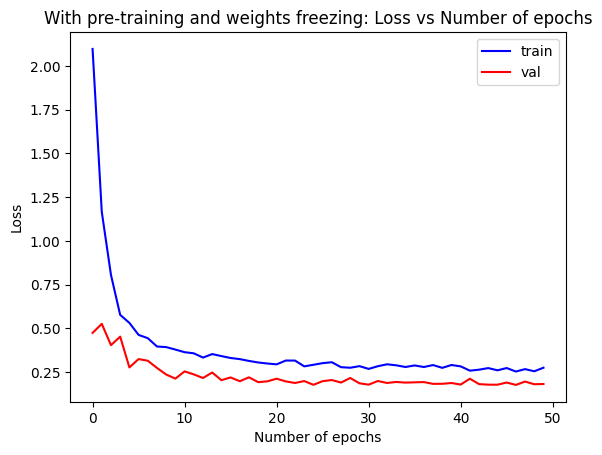

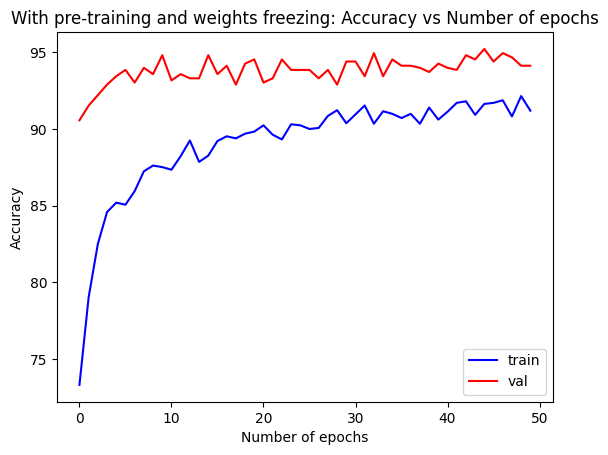

In [ ]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("With pre-training and weights freezing: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("With pre-training and weights freezing: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
config = {
    'lr': 0.001,
    'momentum': 0.9,
    'weight_decay': 0.0001
}
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/weights/pre_efficientnetv2-s.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

for name, para in net.named_parameters():
    if "head" not in name:
      para.requires_grad_(False)
    else:
      print("training {}".format(name))
criterion = nn.CrossEntropyLoss().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=config['lr'],
                       weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for epoch in range(1, 51):
    train_loss_, train_acc_ = train(epoch, net, criterion, train_loader, scheduler)
    val_loss_, val_acc_ = test(epoch, net, criterion, val_loader)
    
    print(("Epoch : %3d, training loss : %0.4f, training accuracy : %2.2f, val loss " + \
      ": %0.4f, val accuracy : %2.2f") % (epoch, train_loss_, train_acc_, val_loss_, val_acc_))
    
    train_loss.append(train_loss_)
    val_loss.append(val_loss_)
    train_acc.append(train_acc_)
    val_acc.append(val_acc_)

<All keys matched successfully>
training head.project_conv.conv.weight
training head.project_conv.bn.weight
training head.project_conv.bn.bias
training head.classifier.weight
training head.classifier.bias
Epoch :   1, training loss : 0.7110, training accuracy : 77.07, val loss : 0.3949, val accuracy : 91.11
Epoch :   2, training loss : 0.5136, training accuracy : 82.24, val loss : 0.2932, val accuracy : 93.30
Epoch :   3, training loss : 0.4494, training accuracy : 84.79, val loss : 0.2228, val accuracy : 92.89
Epoch :   4, training loss : 0.4129, training accuracy : 86.70, val loss : 0.2404, val accuracy : 93.98
Epoch :   5, training loss : 0.4042, training accuracy : 85.95, val loss : 0.1945, val accuracy : 93.57
Epoch :   6, training loss : 0.3765, training accuracy : 86.53, val loss : 0.2040, val accuracy : 94.39
Epoch :   7, training loss : 0.3727, training accuracy : 87.41, val loss : 0.2083, val accuracy : 93.30
Epoch :   8, training loss : 0.3244, training accuracy : 88.67, val

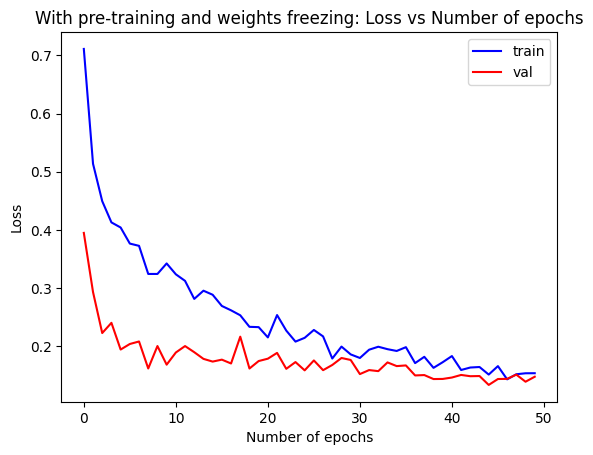

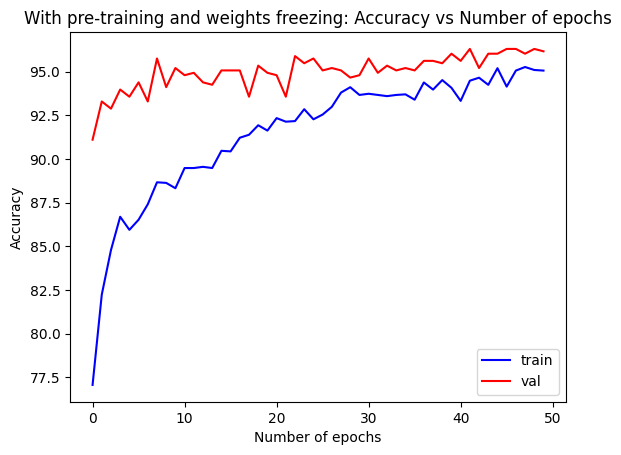

In [ ]:
plt.figure()
plt.plot(range(len(train_loss)), train_loss, 'b')
plt.plot(range(len(val_loss)), val_loss, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.title("With pre-training and weights freezing: Loss vs Number of epochs")
plt.legend(['train', 'val'])

plt.figure()
plt.plot(range(len(train_acc)), train_acc, 'b')
plt.plot(range(len(val_acc)), val_acc, 'r')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title("With pre-training and weights freezing: Accuracy vs Number of epochs")
plt.legend(['train', 'val'])
plt.show()

In [ ]:
torch.save(net.state_dict(), 'FGM_pretrain_e05.pth')

In [ ]:
device = 'cuda'
net = EfficientNetV2().to('cuda')

weights_dict = torch.load("/content/DL_EfficientNet/FGM_with_pretrain.pth", map_location=device)
load_weights_dict = {k: v for k, v in weights_dict.items() if net.state_dict()[k].numel() == v.numel()}
print(net.load_state_dict(load_weights_dict, strict=False))

In [ ]:
import os
import random
import torch
import torch.optim as optim

class AddNoise(object):
    def __init__(self, s=0.5, p=0.9):
        assert isinstance(s, float) or (isinstance(p, float))
        self.s = s
        self.p = p

    def __call__(self, img):
        if random.uniform(0, 1) < self.p:
            img_ = np.array(img).copy()
            h, w, c = img_.shape
            signal_pct = self.s
            noise_pct = (1 - self.s)
            mask = np.random.choice((0, 1, 2), size=(h, w, 1), p=[signal_pct, noise_pct / 2., noise_pct / 2.])
            mask = np.repeat(mask, c, axis=2)
            img_[mask == 1] = 255
            img_[mask == 2] = 0
            return Image.fromarray(img_.astype('uint8')).convert('RGB')
        else:
            return img
        


train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./data/flower_photos")
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(300),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]),
    "val": transforms.Compose([transforms.Resize(384),
        AddNoise(0.7, p=1),
        transforms.CenterCrop(384),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])}

train_dataset = MyDataSet(images_path = train_images_path,images_class = train_images_label,transform=data_transform["train"])

val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform["val"])

batch_size = 8
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))
train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               pin_memory=True,
                                               num_workers=nw,
                                               collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)

In [ ]:
criterion = nn.CrossEntropyLoss().to('cuda')
val_loss_, val_acc_ = test(0, net, criterion, val_loader)
print(val_loss_, val_acc_)